# -- Objetivo do problema
    
    --1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Por que?
        --Quak tipo de modelo de negócio do Airbnb
            --Marketplace( Conecta pessoas que oferecem acamodação, com pessoas que estão procurando acomodação )
            --Oferta ( pessoas oferecendo acomodação )
                -- Tamanho do portfolio
                -- Diversidade/densidade de portfolio.
                -- Preço Médio
                
            -- Demanda ( pessoas procurando acomodação )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client acquisition cost )
                
            -- Gross Revenue = (phi*Numero cliente) - CAC
                
            -- Demanda ( pessoas procurando acomodação )
            
--Proposta da solução
  - Modelo de previsão do primeiro destino de um novo usuário.
  - 1.0. Predições e salvar em uma tabela do banco de dados.
  - 2.0. API
        - Input: usuário e suas caracteristicas
        - output: usuario e suas caracteristicas com a coluna prediction

# 0.0. Imports 

In [1]:
import random

import pandas  as pd 
import numpy   as np 
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import classification_report, accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot.metrics      import plot_confusion_matrix

from scipy.stats             import skewnorm
from scipy                   import stats


from keras import models
from keras import layers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.1. Helper Functions 

In [3]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

def cramer_v( x, y ):
    
    cm   = pd.crosstab( x, y ).values
    n    = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr    = k - (k-1)**2/(n-1)
    rcorr    = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1,rcorr-1) ) )

# 1.0. Data Description

In [4]:
# df users
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )

# df sessions
df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )


## Users

In [5]:
df_raw.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US



## Sessions

In [6]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.000
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.000


## 1.1. Data Dimension  


## Users

In [49]:
print(f'Number of Rows: {df_raw.shape[0]}') 
print(f'Number of Columns: {df_raw.shape[1]}') 

Number of Rows: 213451
Number of Columns: 16



## Sessions

In [50]:
print(f'Number of Rows: {df_sessions.shape[0]}') 
print(f'Number of Columns: {df_sessions.shape[1]}') 

Number of Rows: 10567737
Number of Columns: 6


## 1.2. Data types 


## Users

In [51]:
df_raw.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object


## Sessions

In [52]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA 


## Users

In [53]:
df_raw.isnull().sum() / len(df_raw)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.583
gender                    0.000
age                       0.412
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.028
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64


## Sessions

In [54]:
df_sessions.isnull().sum() / len(df_sessions)

user_id         0.003
action          0.008
action_type     0.107
action_detail   0.107
device_type     0.000
secs_elapsed    0.013
dtype: float64

## 1.4. Check Blanced Data

In [9]:
df_raw['country_destination'].value_counts( normalize=True )

NDF     0.583
US      0.292
other   0.047
FR      0.024
IT      0.013
GB      0.011
ES      0.011
CA      0.007
DE      0.005
NL      0.004
AU      0.003
PT      0.001
Name: country_destination, dtype: float64

## 1.5. Description Analysis 

In [84]:
num_attributes = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes = df_raw.select_dtypes( include='object')

num_attributes_sessions = df_sessions.select_dtypes( include=['int64','float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( include='object' )

### Categorical Variables 


#### Users 

In [106]:
# df2
cat_attributes.drop('id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,206468,206468,206468,206468,206468,206468,206468,206468,206468,206468
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91591,147511,199516,133605,133366,108766,177492,89210,63586,119715



#### Sessions 

In [109]:
# df_sessions
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9123594,9123594,9123594,9123594
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2161240,3518629,1754981,2989495


### Numerical variables


#### Users

In [85]:
numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
timestamp_first_active,int64,213451,20130850417367.258,20130911061308.000,9253717046.584,20090319043255.000,20140630235824.000,50311192569.000,-0.862,0.356
age,float64,127,49.668,34.000,155.667,1.000,2014.000,2013.000,12.423,153.569
signup_flow,int64,17,3.267,0.000,7.638,0.000,25.000,25.000,2.234,3.324



#### Sessions 

In [86]:
numeric_statistics( num_attributes_sessions )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
secs_elapsed,float64,318230,19961.825,1369.000,88849.393,0.000,1799977.000,1799977.000,11.138,154.843


# 2.0. Feature Engineering

In [8]:
df2 = df_raw.copy()

## 2.1. FillNA

### 2.1.1. Users 


## Costumers
If the customer didn't have a country destination, they didn't book an apartment to travel to, my solution to this variable is going to be to exchange the NA values for the max date from a first booking. 

## Age
for this variable I decided to fill the null values with a distribution with the same patterns as the variable age.

In [88]:
# date_first_booking
aux = df2[df2['date_first_booking'].isna()]

aux['country_destination'].value_counts( normalize=True )

NDF   1.000
Name: country_destination, dtype: float64

NDF     0.768
US      0.157
other   0.029
FR      0.015
IT      0.009
GB      0.006
ES      0.006
CA      0.004
DE      0.002
NL      0.002
AU      0.001
PT      0.001
Name: country_destination, dtype: float64 


Skew: 0.820838375560214
std: 9.99858442690581
mean: 35.45384731341284


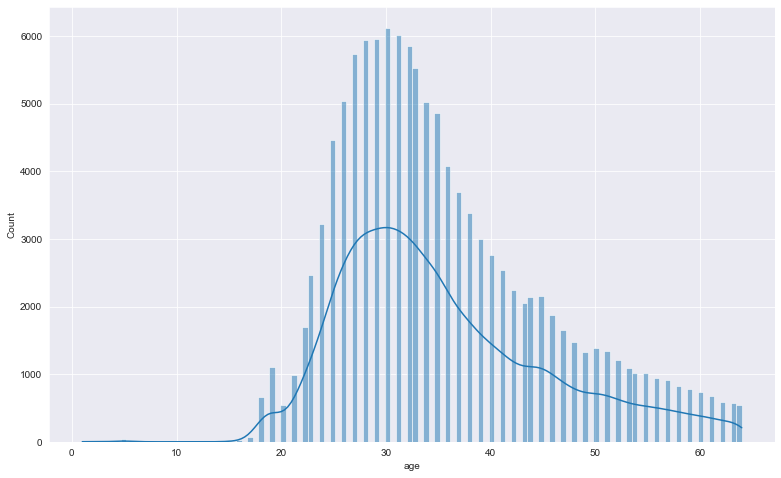

In [89]:
# age
aux = df2[df2['age'].isna()]
print( aux['country_destination'].value_counts( normalize=True ), '\n\n')

skew = df2[df2['age']<65]['age'].skew()
print(f'Skew: {skew}')

std = df2[df2['age']<65]['age'].std()
print(f'std: {std}')

mean = df2[df2['age']<65]['age'].mean()
print(f'mean: {mean}')

sns.histplot( df2[df2['age'] < 65]['age'], kde=True );

In [90]:
# date_first_booking
date_first_booking_max = pd.to_datetime( df2['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df2['date_first_booking'] = df2['date_first_booking'].fillna( date_first_booking_max )

# age
avg_age = df2['age'].mean().astype( 'int64' )
df2['age'] = df2['age'].apply(lambda x: skewnorm.rvs( skew, loc=mean, scale=std ).astype( 'int64' ) if pd.isna(x) else x )

# first_affiliate_tracked
df2 = df2[~df2['first_affiliate_tracked'].isna()]

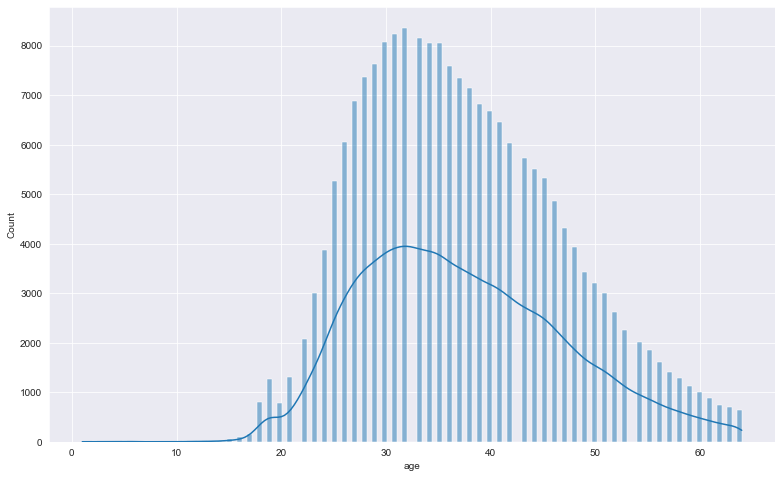

In [91]:
sns.histplot( df2[df2['age'] < 65]['age'], kde=True );

### 2.1.2. df_sessions

In [92]:
# user_id 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_details - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 2.2. Change Data Types 

In [93]:
aux_01 = df2.sample().T
aux_02 = df2.sample().dtypes

pd.concat( [aux_01,aux_02], axis=1 )

,207299,0
id,n1eoknyswu,object
date_account_created,2014-06-19,object
timestamp_first_active,20140619202834,int64
date_first_booking,2015-06-29,object
gender,-unknown-,object
age,29.000,float64
signup_method,basic,object
signup_flow,0,int64
language,en,object
affiliate_channel,direct,object


In [94]:
# df2
# date_account_created
df2['date_account_created'] = pd.to_datetime( df2['date_account_created'] )

# timestamp_first_active
df2['timestamp_first_active'] = pd.to_datetime( df2['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date first_booking 
df2['date_first_booking'] = pd.to_datetime( df2['date_first_booking'] )  
                                           
# age 
df2['age'] = df2['age'].astype( 'int64' )

## 2.3. Check Blanced Data

In [95]:
df2['country_destination'].value_counts( normalize=True )

NDF     0.580
US      0.294
other   0.048
FR      0.024
IT      0.013
GB      0.011
ES      0.011
CA      0.007
DE      0.005
NL      0.004
AU      0.003
PT      0.001
Name: country_destination, dtype: float64

## 2.4. Numerical data 

### 2.4.1 Users

In [102]:
# df2
num_attributes = df2.select_dtypes( include=['int64','float64'] )
cat_attributes = df2.select_dtypes( include='object')
time_attributes = df2.select_dtypes( include='datetime64[ns]')

numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
age,int64,99,38.471,37.000,12.112,16,115,99,1.780,6.614
signup_flow,int64,17,3.156,0.000,7.549,0,25,25,2.284,3.554


### 2.4.2 Sessions

In [104]:
# df_sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64','float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( include='object')
time_attributes_sessions = df_sessions.select_dtypes( include='datetime64[ns]')

numeric_statistics( num_attributes_sessions )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
secs_elapsed,float64,318229,20159.474,1409.000,89265.859,1.000,1799977.000,1799976.000,11.085,153.354


## 2.5. Categorical data 

### 2.5.1 Users 

In [106]:
# df2
cat_attributes.drop('id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,206468,206468,206468,206468,206468,206468,206468,206468,206468,206468
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91591,147511,199516,133605,133366,108766,177492,89210,63586,119715


### 2.5.2 Sessions 

In [109]:
# df_sessions
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9123594,9123594,9123594,9123594
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2161240,3518629,1754981,2989495


<AxesSubplot:>

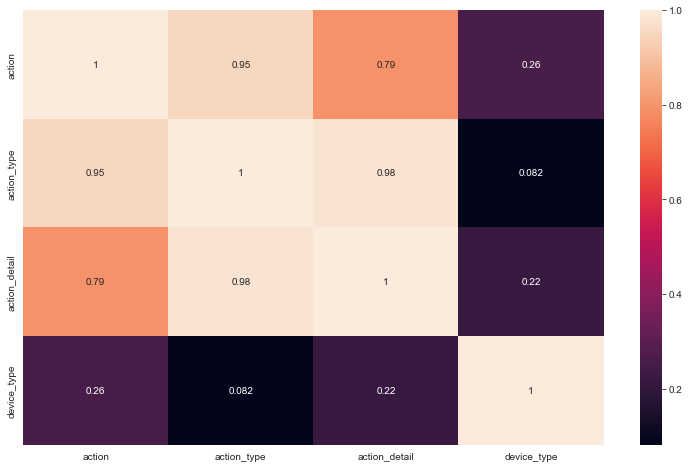

In [120]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# 3.0. Data Filtering

In [16]:
df3 = df2.copy()

In [100]:
# there are few people with these ages and inside the dataset there is lots of weird values od age.
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] <120 )]

df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

In [98]:
aux = df3[df3['age'] > 80][['age','country_destination']]
pd.crosstab( aux['age'], aux['country_destination'] ).sum()

country_destination
AU          8
CA         23
DE         17
ES         32
FR         64
GB         42
IT         57
NDF      1264
NL         13
PT          2
US       1005
other     184
dtype: int64

# 4.0. EDA

In [17]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [18]:
df5 = df4.copy()

df5_dummys = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

df5 = pd.concat( [ df5[['id','country_destination']], df5_dummys], axis=1 )

# 6.0. Feature Selection

In [19]:
df5.columns

Index(['id', 'country_destination', 'date_account_created',
       'timestamp_first_active', 'date_first_booking', 'age', 'signup_flow',
       'gender_-unknown-', 'gender_FEMALE', 'gender_MALE',
       ...
       'first_browser_Safari', 'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser'],
      dtype='object', length=117)

In [20]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking']
df5 = df5.drop( cols_drop, axis=1 )

In [21]:
X = df5.drop( ['id','country_destination'], axis=1 )
y = df5['country_destination'].copy()

# 7.0. Machine Learning

In [22]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=32 )

## 7.1. Baseline model

In [23]:
index = df5['country_destination'].value_counts().index
values = df5['country_destination'].value_counts( normalize=True ).values

In [24]:
yhat_random = random.choices( population=index, weights=values, k=y_val.shape[0] )

In [25]:
# prediction prepare
y_val_random = y_val.to_numpy()

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.523212          0.092667    0.004504
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.02      0.01      0.01       214
          DE       0.02      0.02      0.02       170
          ES       0.02      0.02      0.02       345
          FR       0.06      0.06      0.06       710
          GB       0.05      0.05      0.05       344
          IT       0.02      0.02      0.02       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



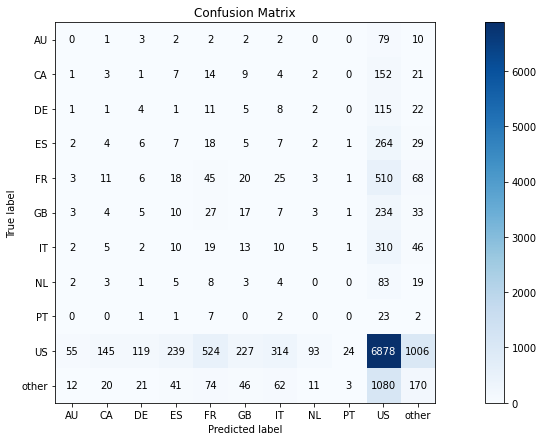

In [26]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_random, yhat_random ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_random, yhat_random ),
    'KappaScore': cohen_kappa_score( y_val_random, yhat_random )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_random, yhat_random ) )

# confusion matrix
plot_confusion_matrix(y_val_random, yhat_random, figsize=(18,7) );

## 7.2. NN 

In [27]:
on = OneHotEncoder()
y_train_nn = on.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [28]:
# model definition
model = models.Sequential()
model.add( layers.Dense( 128, input_dim=X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( X_train, y_train_nn, epochs=100, verbose=0 )

# 8.0. Model Performance 

In [29]:
# prediction
pred_nn = model.predict( X_val )

# invert prediction
yhat_nn =  on.inverse_transform( pred_nn )

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape( 1,-1 )[0]

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.703044          0.091046    0.002663
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.21      0.01      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.08      0.09      0.08     13635
weighted avg       0.52      0.70      0.58     13635



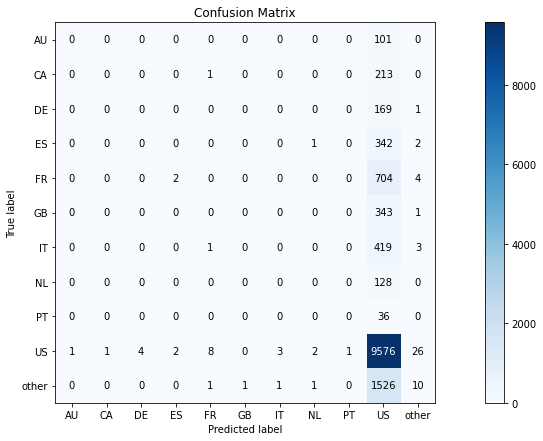

In [30]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_nn, yhat_nn ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_nn, yhat_nn ),
    'KappaScore': cohen_kappa_score( y_val_nn, yhat_nn )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_nn, yhat_nn ) )

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_nn, figsize=(18,7) );

## 8.1. Cross Validation 

In [31]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split( X_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = models.Sequential()
    model.add( layers.Dense( 256, input_dim=X_train.shape[1], activation='relu' ) )
    model.add( layers.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( X_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

print(f'Avg Balanced Accuracy: {np.mean( balanced_acc_list )} +/- {np.std( balanced_acc_list )}' )
print(f'Avg Kappa: {np.mean( kappa_acc_list )} +/- {np.std( kappa_acc_list )}' )

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5
Avg Balanced Accuracy: 0.09155718094644394 +/- 0.00022635929012134227
Avg Kappa: 0.002817943288701352 +/- 0.0017295300685959945
